# Using a K-nearest Neighbours Classifier To Detect Bank Account Opening Fraud
### 2022W2 DSCI 100 Group Project Report

Team Members:
- Aqil Faizal
- Andrei Chepakovich
- Jiaying Ong
- Lucy Liu

## Introduction
Fraud is a major problem in Canada, with a total of $531M being lost to fraud in 2022 according to the Canadian Anti-Fraud Centre. Although overall rates of digital financial fraud in Canada have fallen in recent years, identity theft rates have been on the rise. According to Statista, an online platform for consumer data, the rate of identity fraud in Canada has consistently grown from 2008 to 2021 and sat at 61.95 per 100,000 residents in the latter year. Identity thieves commonly use stolen personal information to create new bank accounts with which they will then perform fraudulent activities such as credit card fraud, fraudulent loan applications, and money laundering. This act is known as account opening fraud, and will be the focus of this group project.

In this project, we aim to use the R tidymodels framework to build a K-nearest neighbours classifier that can classify a bank account as fraudulent or non-fraudulent using data from the Bank Account Fraud suite of datasets published at NeurIPS 2022, a machine learning conference. This synthetic dataset is based on real-world bank account data. The main questions that we would like to answer in this project are: 1) given this data, can we use the K-nearest neighbours algorithm to classify a bank account as fraudulent or non-fraudulent with reasonable accuracy, and 2) which variables are good indicators of account opening fraud?

## Description of the dataset
We used the Base.csv dataset from the aforementioned Bank Account Fraud suite, which has 32 variables and 1M observations. As the K-nearest neighbours algorithm becomes very computationally costly with a large number of observations, we first randomly sampled 100,000 rows of data and then filtered this subset further to obtain only observations with certain attributes.

We also plan to use the forward selection algorithm to select the predictor variables to be used by the KNN model. Since using many variables for forward selection involves the training of many models and increases the chance that we come across a model with a high cross-validation accuracy estimate, but a low true accuracy on the test data, we first examined 6 variables that we felt were most likely to be indicators of fraudulence.

## Methods

### 1. Loading required libraries and data from the web:

The required libraries for running the code in this report are:

- tidyverse
- repr
- tidymodels
- themis
- kknn

In [1]:
### Setup
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
library(kknn)
library(cowplot)

options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Since the dataset has 1M rows, we first downloaded Base.csv locally and randomly sampled 100,000 rows, which we then wrote to a .csv file and hosted on Google Sheets. We then read the data in again from Google Sheets:

In [2]:
fraud_data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRL6hq0R8gYhL5VhHlCOGGSKTea3N54QsEC8zcr5pHwuY2Ly5Zc6G83araSMkzwQF7suK_o6tr-4MEP/pub?output=csv")|>
mutate(fraud_bool=as_factor(fraud_bool))

fraud_data

Rows: 100000 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): payment_type, employment_status, housing_status, source, device_os
dbl (27): fraud_bool, income, name_email_similarity, prev_address_months_cou...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,⋯,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9,0.16682773,-1,88,50,0.020925173,-1.3313450,AA,769,⋯,0,500,0,INTERNET,3.888115,windows,0,1,0,7
1,0.9,0.29628601,-1,144,50,0.005417538,-0.8162238,AB,366,⋯,0,1500,0,INTERNET,31.798819,windows,0,1,0,7
1,0.9,0.04498549,-1,132,40,3.108548793,-0.7557277,AC,870,⋯,0,200,0,INTERNET,4.728705,other,0,1,0,7
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,0.6,0.8435506,-1,18,40,0.01090603,-0.8543749,AB,602,⋯,0,1500,0,INTERNET,5.939641,other,1,1,0,3
0,0.4,0.6882371,-1,50,20,0.02786849,50.3059704,AA,691,⋯,0,500,0,INTERNET,3.273092,linux,1,1,0,3
0,0.7,0.7537215,-1,50,30,0.02482313,98.5380625,AA,878,⋯,1,500,0,INTERNET,6.452148,windows,0,1,0,3


### 2. Narrowing down to potential predictor variables and filtering for certain characteristics

We then narrowed the dataset down to the 6 variables which we felt were most likely to be indicators of fraudulence, as well as the label to be predicted (whether the bank account was fraudulent): 

- Credit risk score
- Income
- Months lived at current address
- Name-email similarity
- Session length in minutes
- Proposed credit limit

In addition, we also filtered for observations with the following characteristics:

- From the month of July
- With the employment status of 'CA' 
- With the housing status of 'BA'

Since the dataset is synthetic, the employment and housing statuses have arbitrary meaning. 

In [3]:
set.seed(9999)

fraud_narrowed <- fraud_data |>
    filter(month == 7, employment_status == "CA", housing_status == "BA") |>
    select(fraud_bool, credit_risk_score, income, current_address_months_count, name_email_similarity, session_length_in_minutes, proposed_credit_limit)    
fraud_narrowed

fraud_bool,credit_risk_score,income,current_address_months_count,name_email_similarity,session_length_in_minutes,proposed_credit_limit
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,185,0.9,88,0.1668277,3.888115,500
1,259,0.9,144,0.2962860,31.798819,1500
1,110,0.9,22,0.1595112,2.047904,200
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,179,0.9,134,0.6891395,2.310369,500
0,234,0.9,3,0.5094120,2.943703,1000
0,244,0.8,131,0.8623505,4.555719,1500


### 3. Randomly split the dataset into a training dataset and a testing dataset

We did this so that we could accurately evaluate our final classification model using testing data it had not yet seen.

In [4]:
fraud_split <- initial_split(fraud_narrowed, prop = 0.75, strata = fraud_bool)
fraud_train <- training(fraud_split)
fraud_test <- testing(fraud_split) 

fraud_train
fraud_test 

number_of_rows <- nrow(fraud_train)
number_of_rows

fraud_bool,credit_risk_score,income,current_address_months_count,name_email_similarity,session_length_in_minutes,proposed_credit_limit
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,185,0.9,88,0.1668277,3.888115,500
1,259,0.9,144,0.2962860,31.798819,1500
1,295,0.9,218,0.5964137,3.775225,1500
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,154,0.9,40,0.04758588,1.075560,200
0,266,0.4,141,0.02963662,5.247373,1000
0,244,0.8,131,0.86235045,4.555719,1500


fraud_bool,credit_risk_score,income,current_address_months_count,name_email_similarity,session_length_in_minutes,proposed_credit_limit
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,110,0.9,22,0.1595112,2.047904,200
1,220,0.9,162,0.6115532,3.531939,200
1,143,0.9,186,0.1254526,3.070971,200
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,46,0.8,137,0.02774166,2.463003,200
0,179,0.9,134,0.68913946,2.310369,500
0,234,0.9,3,0.50941196,2.943703,1000


[1] 11526

### 4. Exploratory data analysis

We were left with 11526 rows of training data. The original dataset was already tidy, so there was no need to wrangle our data. We then visualised the distribution of the potential predictor variables (to determine whether they could be used to predict account opening fraud) as well as the distribution of fraudulence among newly opened accounts.

fraud_bool,count,percentage
<fct>,<int>,<dbl>
0,10922,94.759674
1,604,5.240326


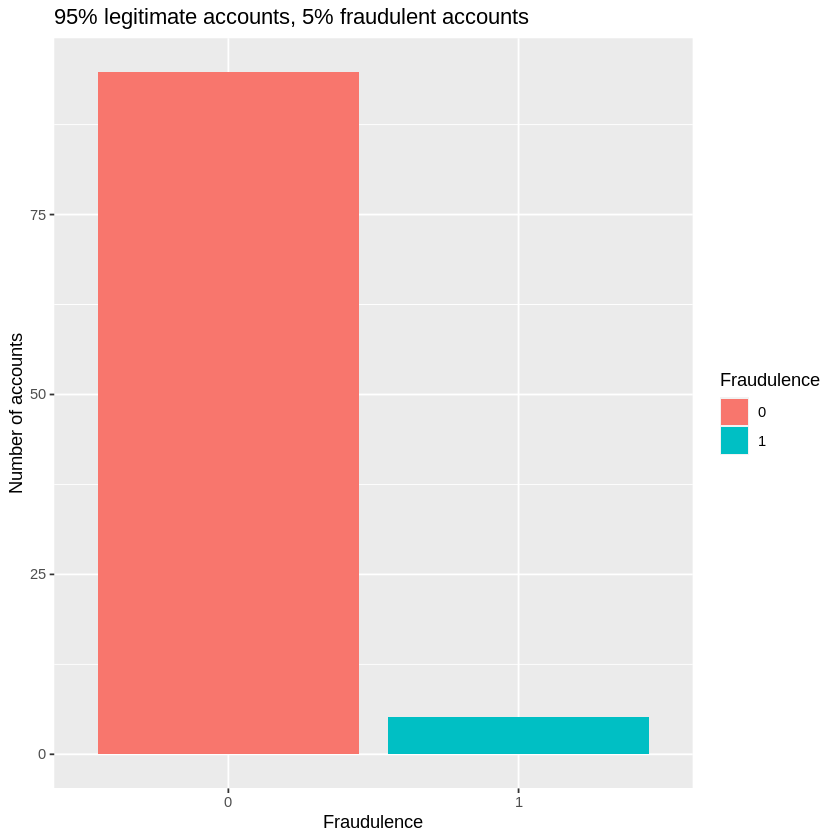

In [5]:
fraud_ratio_train <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(count = n()) 

fraud_percentages <- fraud_ratio_train |>
    mutate(percentage = (count / number_of_rows) * 100)

fraud_percentages_plot <- fraud_percentages |>
    ggplot(aes(x = fraud_bool, y = percentage, fill = fraud_bool)) +
    geom_bar(stat = "identity") +
    xlab("Fraudulence") +
    ylab("Number of accounts") +
    labs(fill = "Fraudulence") + 
    ggtitle("95% legitimate accounts, 5% fraudulent accounts")

fraud_percentages
fraud_percentages_plot

fraud_bool,credit
<fct>,<dbl>
0,180.2160
1,206.5281


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



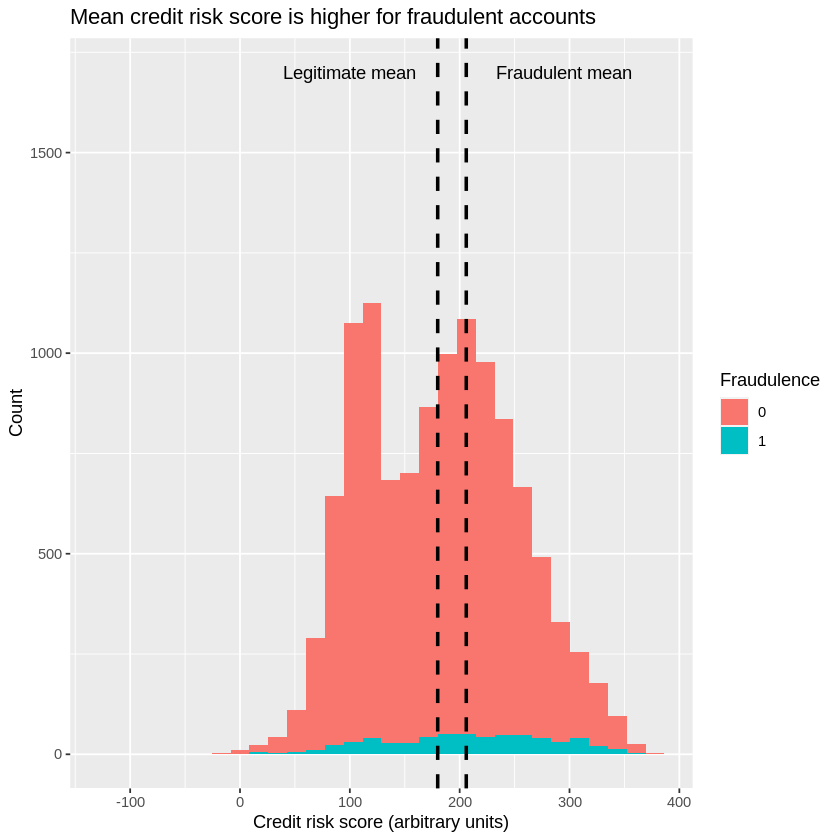

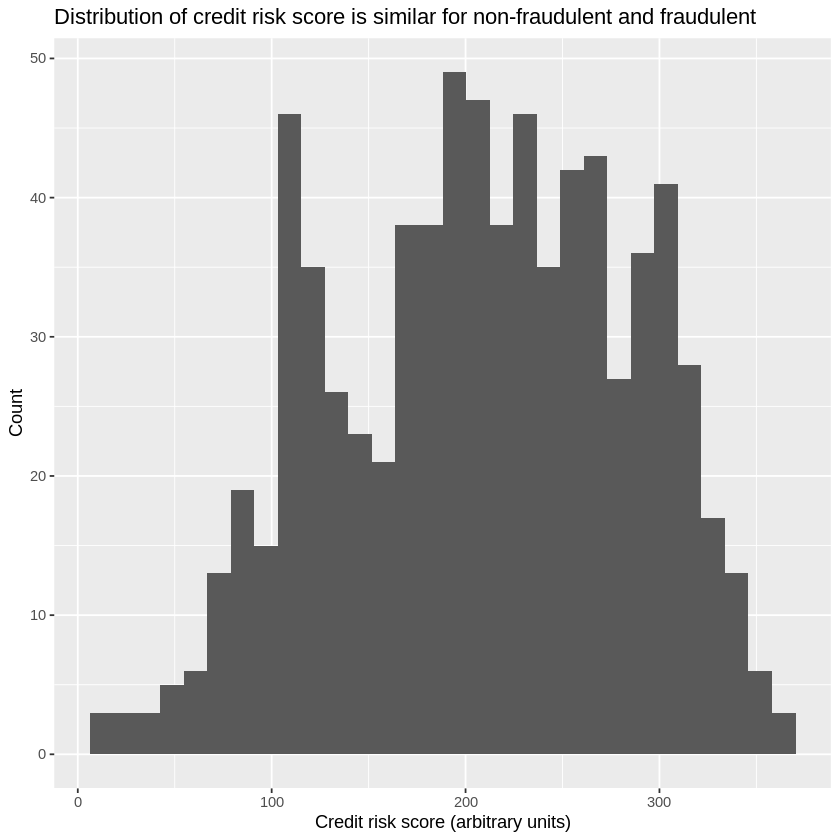

In [6]:
average_credit_risk_score <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(credit = mean(credit_risk_score))

average_credit_risk_score

credit_risk_score_plot <- ggplot(fraud_train, aes(x = credit_risk_score, fill = fraud_bool)) +
  geom_histogram() +
  labs(fill = "Fraudulence") +
  xlab("Credit risk score (arbitrary units)") +
  ylab("Count") +
  geom_vline(xintercept = 180, linetype = "dashed", size = 1) +
  geom_vline(xintercept = 206, linetype = "dashed", size = 1) +
  annotate("text", x = 100, y = 1700, label = "Legitimate mean") +
  annotate("text", x = 295, y = 1700, label = "Fraudulent mean") +
  ggtitle("Mean credit risk score is higher for fraudulent accounts")

  fraud_credit_risk_score_plot <- fraud_narrowed |>
  filter(fraud_bool == 1) |>
  ggplot(aes(x = credit_risk_score)) +
  geom_histogram() +
  xlab("Credit risk score (arbitrary units)") +
  ylab("Count") + 
  ggtitle("Distribution of credit risk score is similar for non-fraudulent and fraudulent")

credit_risk_score_plot
fraud_credit_risk_score_plot

fraud_bool,income
<fct>,<dbl>
0,0.6914942
1,0.7382450


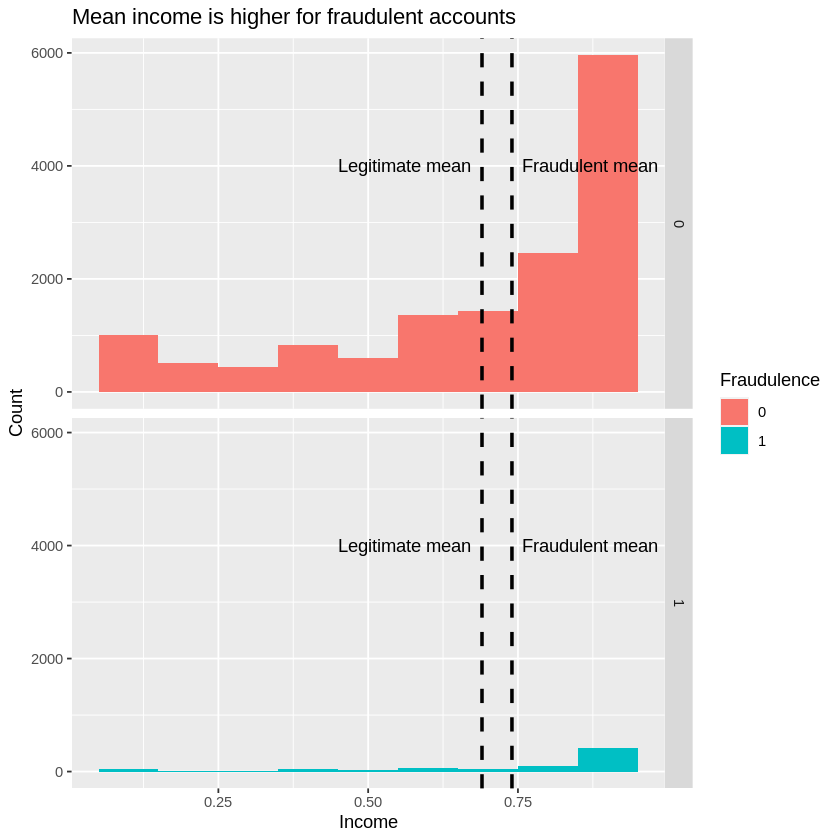

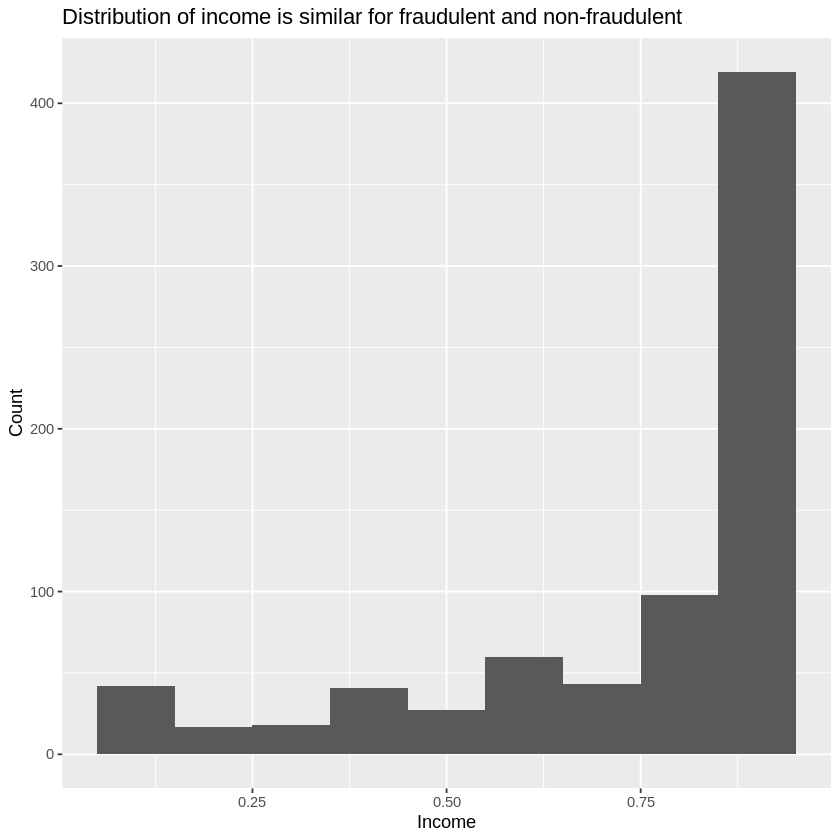

In [7]:
average_income <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(income = mean(income))

average_income

income_plot <- ggplot(fraud_narrowed, aes(x = income, fill = fraud_bool)) +
  geom_histogram(binwidth = 0.1) +
  labs(fill = "Fraudulence") +
  xlab("Income") +
  ylab("Count") +
  geom_vline(xintercept = 0.69, linetype = "dashed", size = 1) +
  geom_vline(xintercept = 0.74, linetype = "dashed", size = 1) +
  annotate("text", x = 0.56, y = 4000, label = "Legitimate mean") +
  annotate("text", x = 0.87, y = 4000, label = "Fraudulent mean") +
  facet_grid(rows = vars(fraud_bool)) +
  ggtitle("Mean income is higher for fraudulent accounts")

fraud_income_plot <- fraud_narrowed |>
  filter(fraud_bool == 1) |>
  ggplot(aes(x = income)) +
  geom_histogram(binwidth = 0.1) +
  xlab("Income") +
  ylab("Count") + 
  ggtitle("Distribution of income is similar for fraudulent and non-fraudulent")
  

income_plot
fraud_income_plot

fraud_bool,address
<fct>,<dbl>
0,108.8403
1,111.2798


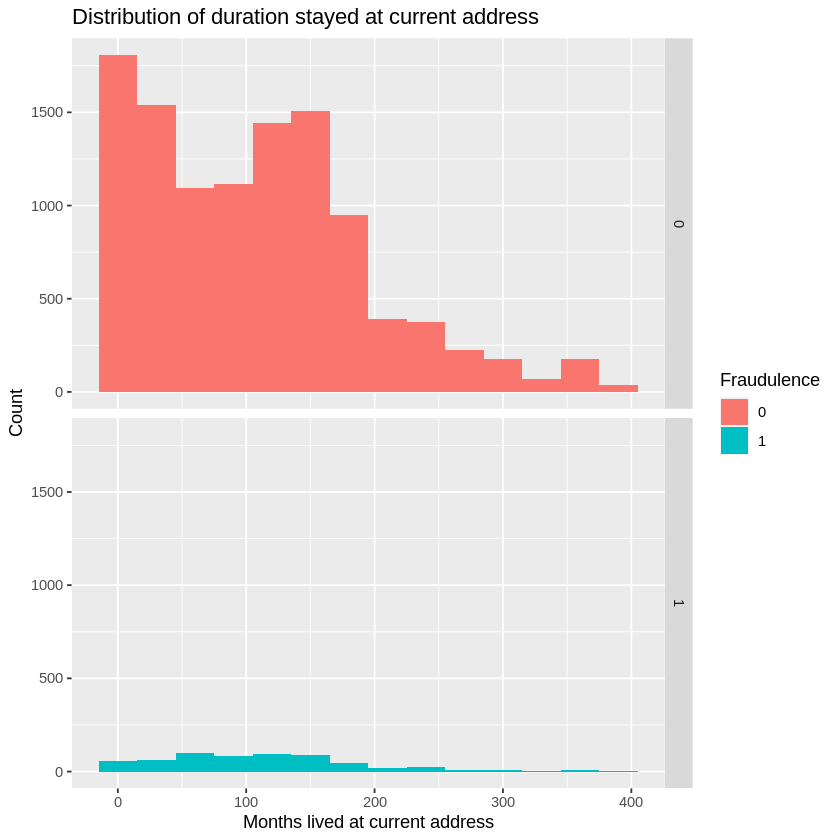

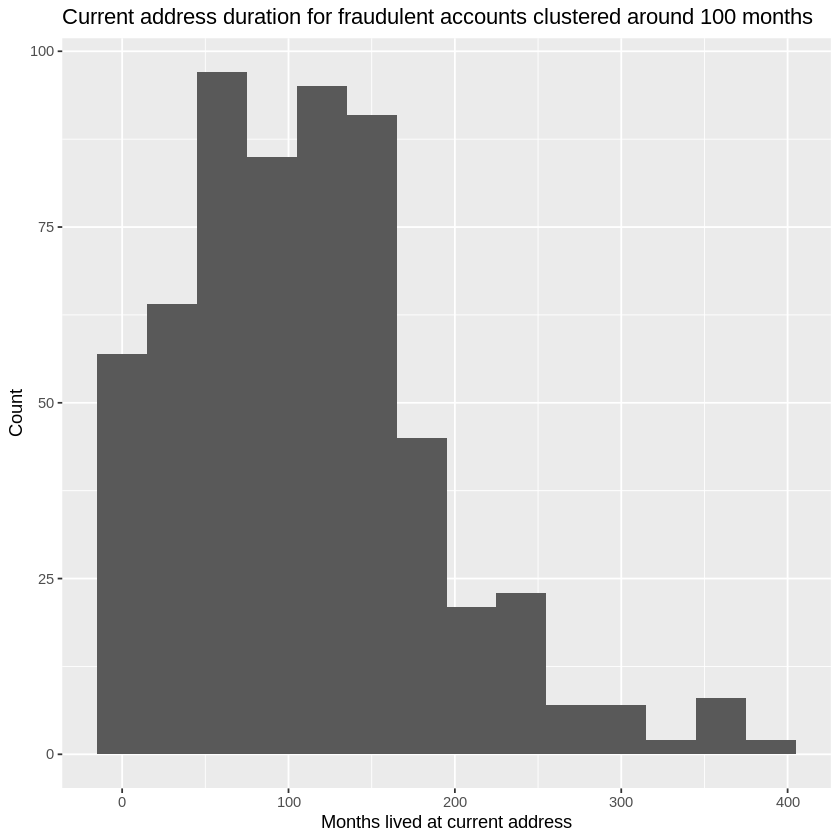

In [8]:
average_address_duration <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(address = mean(current_address_months_count))

average_address_duration

address_duration_plot <- ggplot(fraud_train, aes(x = current_address_months_count, fill = fraud_bool)) +
  geom_histogram(binwidth = 30) +
  labs(fill = "Fraudulence") +
  xlab("Months lived at current address") +
  ylab("Count") +
  facet_grid(rows = vars(fraud_bool)) +
  ggtitle("Distribution of duration stayed at current address")

fraud_address_duration <- fraud_train |>
  filter(fraud_bool == 1) |>
  ggplot(aes(x = current_address_months_count)) +
  geom_histogram(binwidth = 30) +
  xlab("Months lived at current address") +
  ylab("Count") +
  ggtitle("Current address duration for fraudulent accounts clustered around 100 months")

address_duration_plot
fraud_address_duration

fraud_bool,similarity
<fct>,<dbl>
0,0.4965410
1,0.3989186


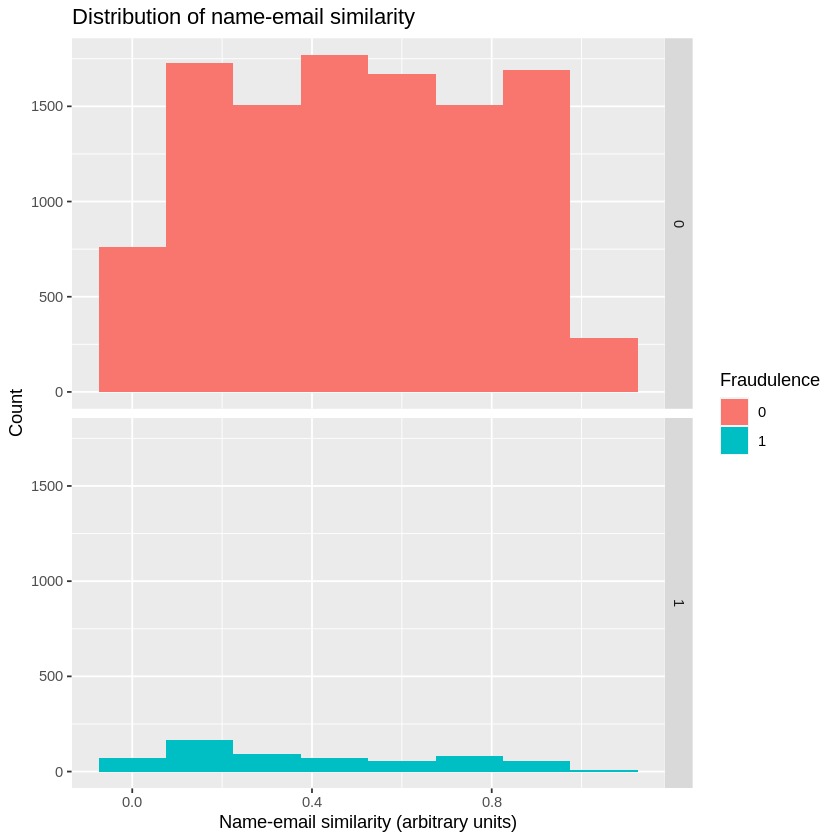

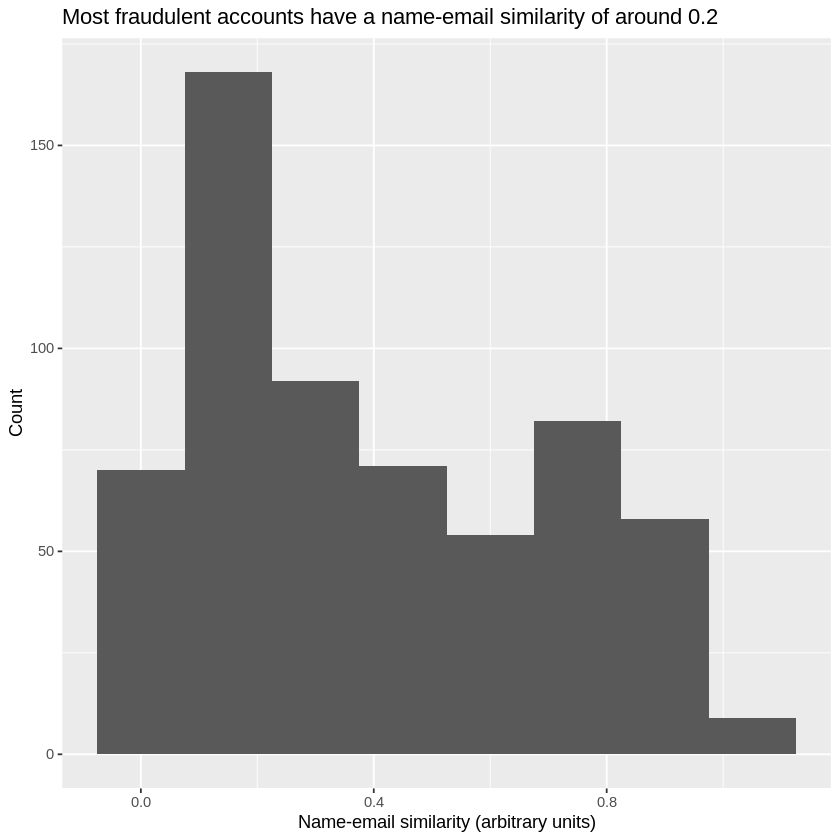

In [9]:
average_similarity <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(similarity = mean(name_email_similarity))

average_similarity 

similarity_plot <- ggplot(fraud_train, aes(x = name_email_similarity, fill = fraud_bool)) +
  geom_histogram(binwidth = 0.15) +
  labs(fill = "Fraudulence") +
  xlab("Name-email similarity (arbitrary units)") +
  ylab("Count") +
  facet_grid(rows = vars(fraud_bool)) +
  ggtitle("Distribution of name-email similarity")

fraud_similarity_duration <- fraud_train |>
  filter(fraud_bool == 1) |>
  ggplot(aes(x = name_email_similarity)) +
  geom_histogram(binwidth = 0.15) +
  xlab("Name-email similarity (arbitrary units)") +
  ylab("Count") +
  ggtitle("Most fraudulent accounts have a name-email similarity of around 0.2")

similarity_plot
fraud_similarity_duration

fraud_bool,session_length
<fct>,<dbl>
0,5.886810
1,7.125959


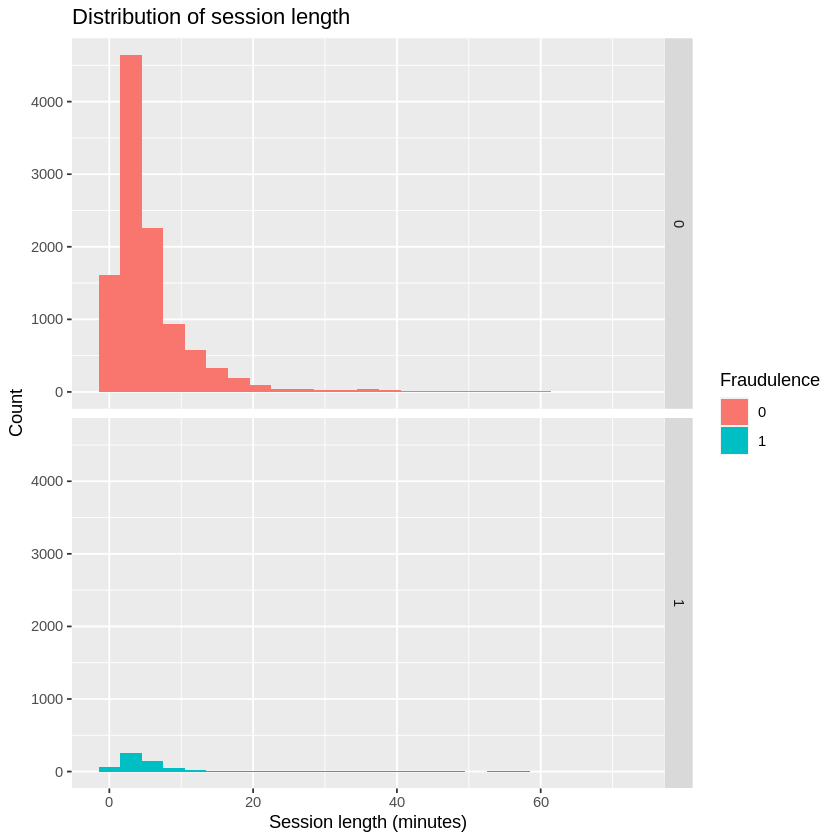

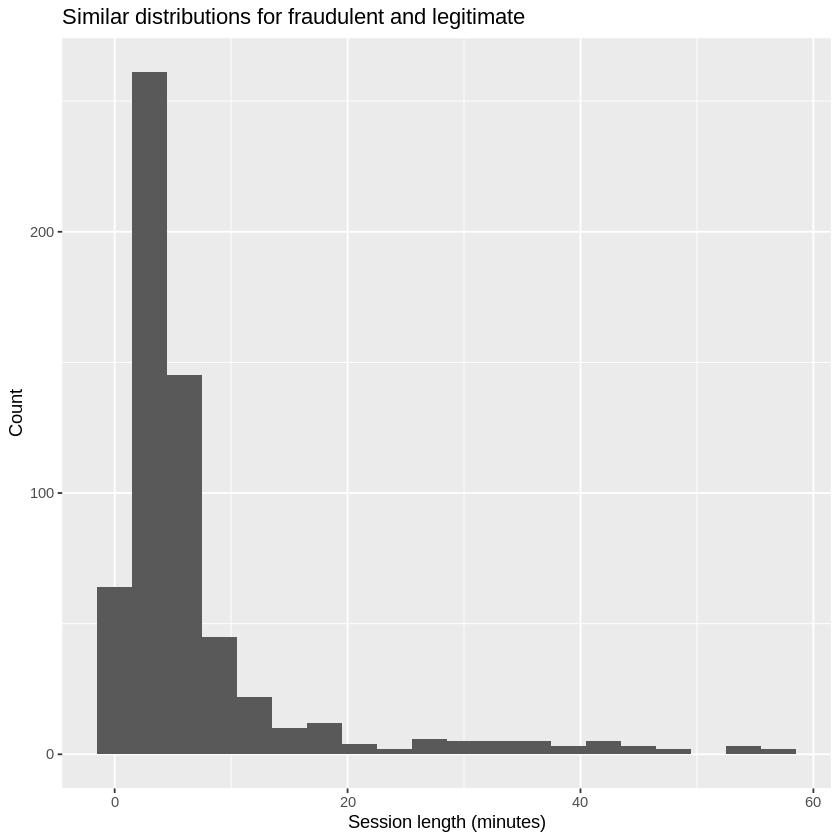

In [10]:
average_session <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(session_length = mean(session_length_in_minutes))

average_session

session_plot <- ggplot(fraud_train, aes(x = session_length_in_minutes, fill = fraud_bool)) +
  geom_histogram(binwidth = 3) +
  labs(fill = "Fraudulence") +
  xlab("Session length (minutes)") +
  ylab("Count") +
  facet_grid(rows = vars(fraud_bool)) +
  ggtitle("Distribution of session length")

fraud_session_duration <- fraud_train |>
  filter(fraud_bool == 1) |>
  ggplot(aes(x = session_length_in_minutes)) +
  geom_histogram(binwidth = 3) +
  xlab("Session length (minutes)") +
  ylab("Count") +
  ggtitle("Similar distributions for fraudulent and legitimate")

session_plot
fraud_session_duration

fraud_bool,proposed_credit_limit
<fct>,<dbl>
0,716.1710
1,970.3311


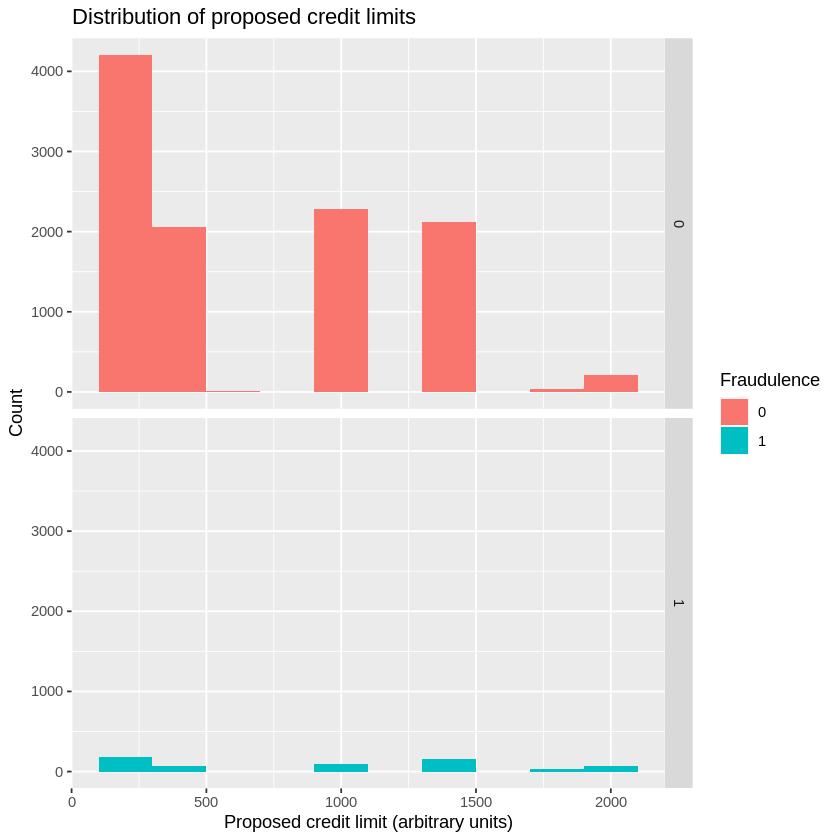

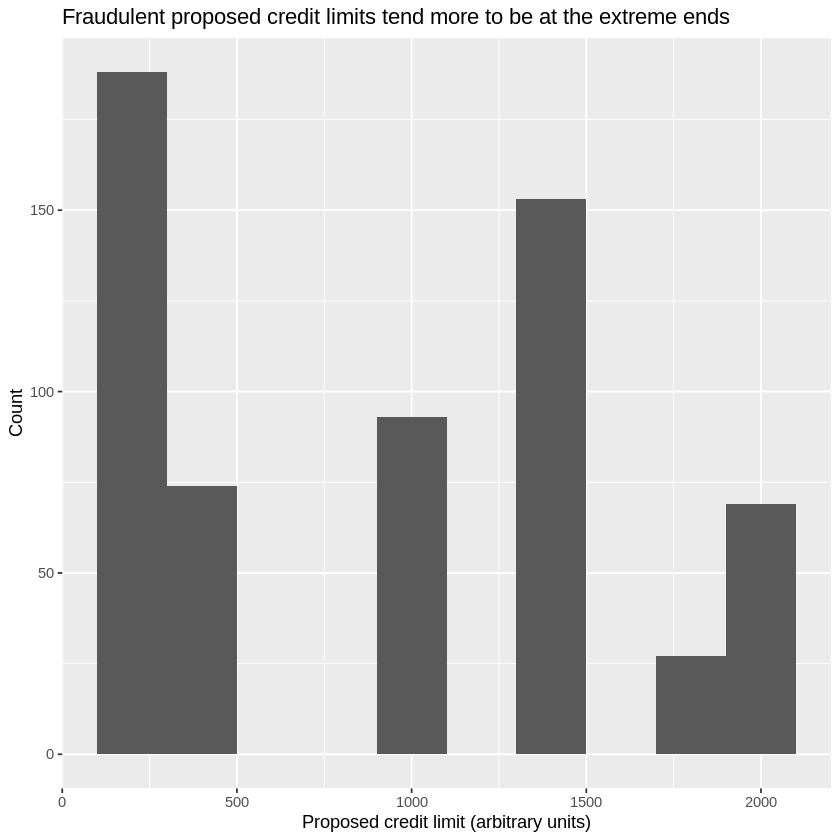

In [11]:
average_proposed_credit_limit <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(proposed_credit_limit = mean(proposed_credit_limit))

proposed_credit_limit_plot <- ggplot(fraud_train, aes(x = proposed_credit_limit, fill = fraud_bool)) +
  geom_histogram(binwidth = 200) +
  labs(fill = "Fraudulence") +
  xlab("Proposed credit limit (arbitrary units)") +
  ylab("Count") +
  facet_grid(rows = vars(fraud_bool)) +
  ggtitle("Distribution of proposed credit limits")

fraud_proposed_credit_limit <- fraud_train |>
  filter(fraud_bool == 1) |>
  ggplot(aes(x = proposed_credit_limit)) +
  geom_histogram(binwidth = 200) +
  xlab("Proposed credit limit (arbitrary units)") +
  ylab("Count") +
  ggtitle("Fraudulent proposed credit limits tend more to be at the extreme ends")

average_proposed_credit_limit
proposed_credit_limit_plot
fraud_proposed_credit_limit

The preliminary data exploration told us that:

- Fraudulent and legitimate bank accounts have similar distributions for session length, credit risk score, and income
- But, they differ for the other 3 variables

Thus, we decided to proceed with forward selection with these 5 variables:

- Months lived at current address
- Name-email similarity
- Proposed credit limit

We also learned that legitimate bank accounts (95%) far outnumber fraudulent bank accounts (5%), so class balancing might be required.

### 5. Class Balancing
We accounted for the rarity of fraudulent accounts by oversampling fraudulent accounts. We tentatively set the oversampling ratio as 0.25 so that a reasonable amount of computational power would be needed for the next steps.

In [12]:
ups_recipe <- recipe(fraud_bool ~ ., data = fraud_train) |>
  step_upsample(fraud_bool, over_ratio = 0.25, skip = FALSE) |>
  prep()

upsampled_fraud <- bake(ups_recipe, fraud_train)

upsampled_fraud |>
  group_by(fraud_bool) |>
  summarize(n = n())

fraud_bool,n
<fct>,<int>
0,10922
1,2730


### 6. Predictor variable selection with data preprocessing

On the aforementioned 3 variables, we used the forward selection algorithm together with recipes that scaled and balanced the data. We chose 2 folds for the cross-validation part to again keep the computational power requirement reasonable.

In [13]:
fraud_subset <- upsampled_fraud |>
    select(fraud_bool, current_address_months_count, name_email_similarity,  proposed_credit_limit)

names <- colnames(fraud_subset |> select(-fraud_bool))

accuracies <- tibble(
    size = integer(),
    model_string = character(),
    accuracy = numeric()
)

knn_spec <- nearest_neighbor(
    weight_func = "rectangular",
    neighbors = tune()
) |>
    set_engine("kknn") |>
    set_mode("classification")

fraud_vfold <- vfold_cv(fraud_subset, v = 2, strata = fraud_bool)

n_total <- length(names)

selected <- c()

for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("fraud_bool", "~", paste(preds_new, collapse = "+"))

        # create a recipe from the model string
        fraud_recipe <- recipe(as.formula(model_string),
            data = fraud_subset) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

        # tune the KNN classifier with these predictors,
        # and collect the accuracy for the best K
        acc <- workflow() |>
            add_recipe(fraud_recipe) |>
            add_model(knn_spec) |>
            tune_grid(resamples = fraud_vfold, grid = 5) |>
            collect_metrics() |>
            filter(.metric == "accuracy") |>
            summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |>
        add_row(
            size = i,
            model_string = models[[jstar]],
            accuracy = accs[[jstar]]
        )
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies


In [14]:
accuracies_arranged <- accuracies |>
    arrange(desc(accuracy))

accuracies_arranged

The forward selection algorithm results informed us that using only these 2 predictor variables: 
- name-email similarity
- months lived at the current address 

would be a good choice. 

### 7. Model tuning

First, we specified a recipe to scale and center the data. Then, we created a KNN model for tuning purposes, then used 5-fold cross validation to tune the model. Next, we visualized the results and picked the best K-value. 


In [15]:
fraud_recipe <- recipe(fraud_bool ~ name_email_similarity + current_address_months_count, data = fraud_subset) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

tune_vfold <- vfold_cv(fraud_subset, v = 5, strata = fraud_bool)

knn_results <- workflow() |>
  add_recipe(fraud_recipe) |>
  add_model(tune_spec) |>
  tune_grid(resamples = tune_vfold, grid = 10) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9644741,5,0.001055287,Preprocessor1_Model1
3,accuracy,binary,0.9099776,5,0.003277668,Preprocessor1_Model2
5,accuracy,binary,0.8573844,5,0.002845646,Preprocessor1_Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
10,accuracy,binary,0.8093324,5,0.003805571,Preprocessor1_Model6
12,accuracy,binary,0.8029597,5,0.004224391,Preprocessor1_Model7
14,accuracy,binary,0.8036186,5,0.002410098,Preprocessor1_Model8


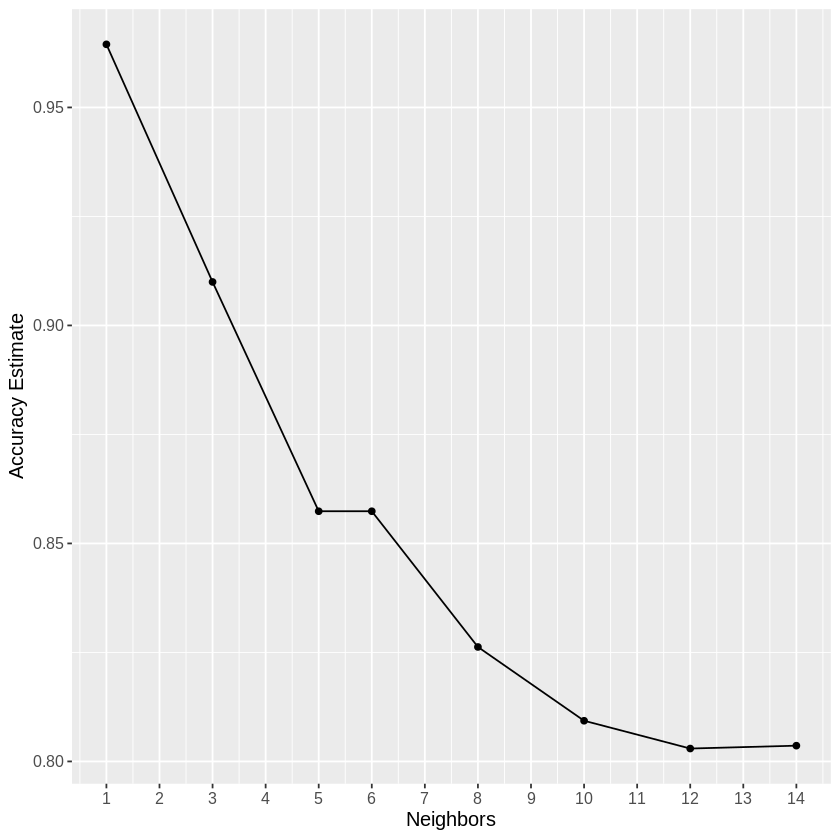

In [16]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12)) +
  scale_x_continuous(breaks=seq(0,14,1))

accuracy_vs_k

Looking at the curve, we saw that K=2 is the best K-value, as it yields the highest accuracy estimate.

### 8. Obtaining of best K-value model

Knowing that the two ideal predictor variables are name-email similarity and amount of months lived at current address, and that the best K-value is 2, we trained the best K-value model:

In [17]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(fraud_recipe) |>
  add_model(knn_spec) |>
  fit(data = fraud_subset)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.0332552
Best kernel: rectangular
Best k: 2

## Results
Using the best K-value model, we predicted the fraudulence labels of the testing dataset in order to find out the accuracy of the model.

In [18]:
fraud_test_predictions <- predict(knn_fit, fraud_test) |>
  bind_cols(fraud_test)

fraud_test_predictions

fraud_accuracy <- fraud_test_predictions |>
  metrics(truth = fraud_bool, estimate = .pred_class) |>
  filter(.metric == "accuracy")
fraud_accuracy

.pred_class,fraud_bool,credit_risk_score,income,current_address_months_count,name_email_similarity,session_length_in_minutes,proposed_credit_limit
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,110,0.9,22,0.1595112,2.047904,200
0,1,220,0.9,162,0.6115532,3.531939,200
0,1,143,0.9,186,0.1254526,3.070971,200
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,0,46,0.8,137,0.02774166,2.463003,200
0,0,179,0.9,134,0.68913946,2.310369,500
0,0,234,0.9,3,0.50941196,2.943703,1000


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8860265


### 9. Model specification, usage, and evaluation

To begin we shall compare the accuracy of our classifier to the majority classifier.

In [20]:
upsampled_fraud_proportion <- upsampled_fraud |>
                      group_by(fraud_bool) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(upsampled_fraud))
upsampled_fraud_proportion



fraud_bool,n,percent
<fct>,<int>,<dbl>
0,10922,80.00293
1,2730,19.99707


In this we can see our classifier has a higher percentage accuracy with 89% compared to the 80% of the majority classifier showing that the classifier has improved a bit from the majority classifier. However, it is important to look into the confusion matrix of our classifier to see if this performance is adequate for detecting bank fraud.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



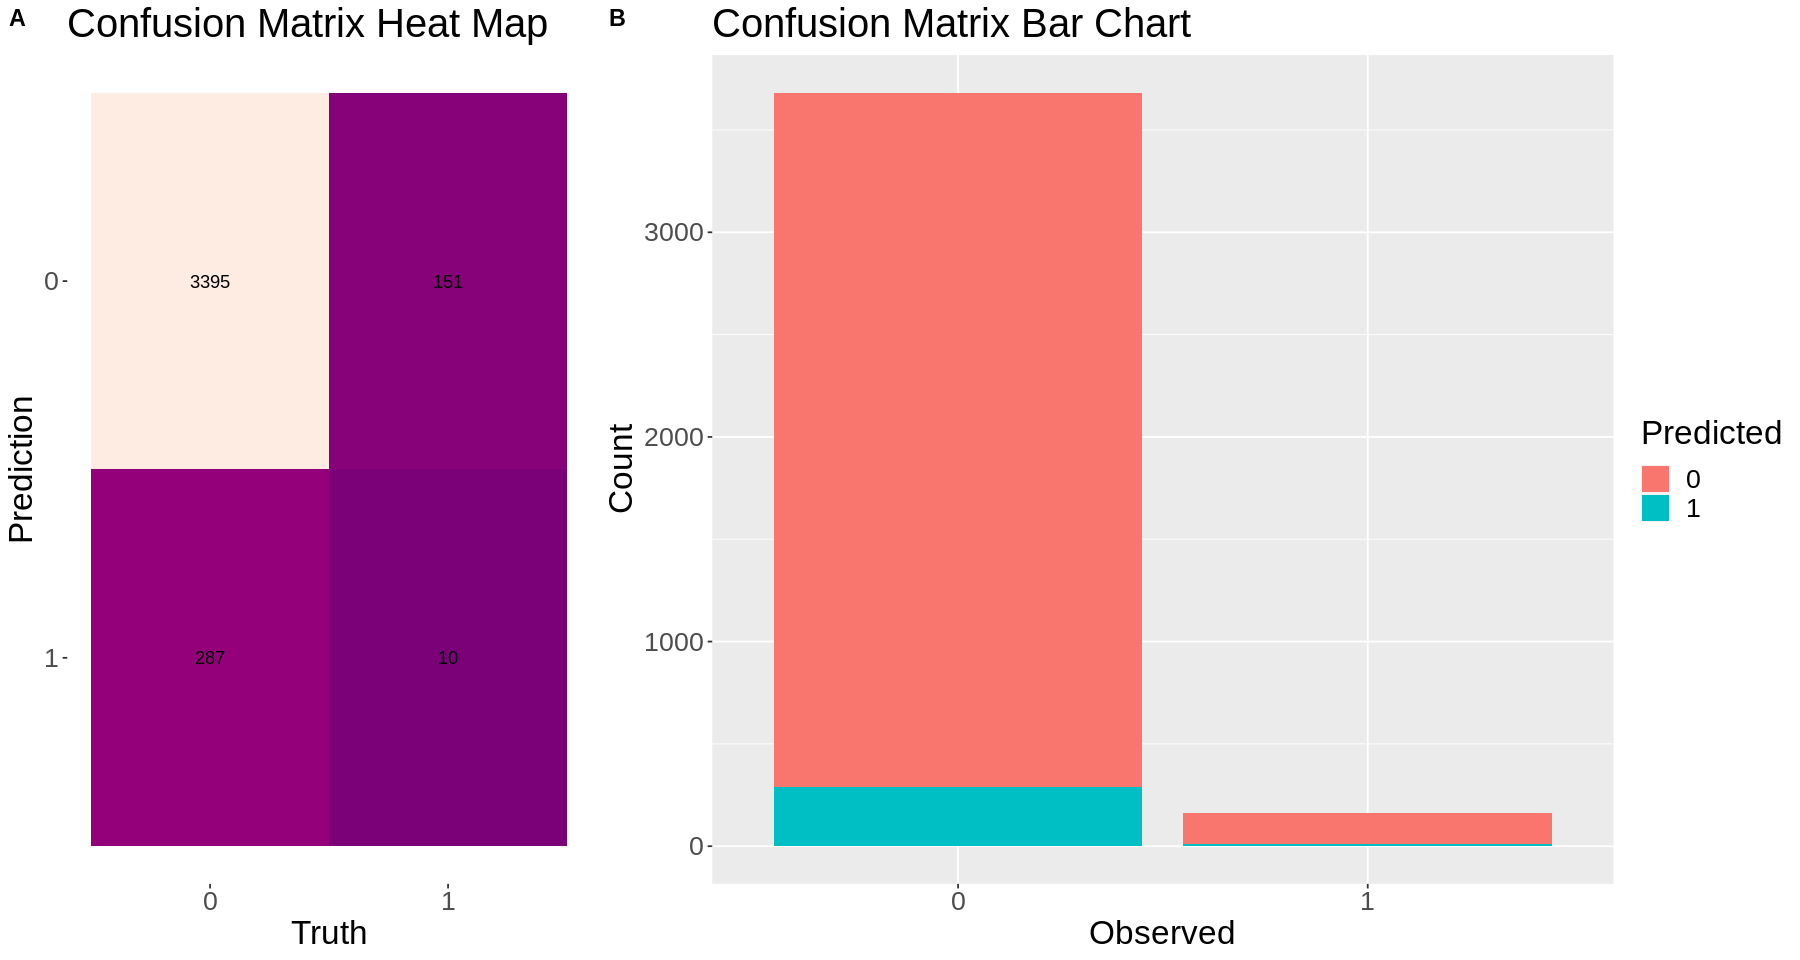

In [70]:
options(repr.plot.width=15, repr.plot.height=8)

fraud_confusion <- fraud_test_predictions |>
             conf_mat(truth = fraud_bool, estimate = .pred_class) |>
                autoplot(type = "heatmap") +
                theme(text = element_text(size = 20)) +
                ggtitle("Confusion Matrix Heat Map") +
                scale_fill_distiller(palette = "RdPu")

fraud_confusion_tibble <- fraud_test_predictions |>
    select(.pred_class, fraud_bool) |>
    table() |>
    as_tibble()

conf_plot <- fraud_confusion_tibble |>
    ggplot(aes(x = fraud_bool, y = n, fill = .pred_class, position = "fill")) +
        geom_bar(stat = "identity") +
        labs(x = "Observed", y = "Count", fill = "Predicted") +
        theme(text = element_text(size = 20)) +
        ggtitle("Confusion Matrix Bar Chart") +
        scale_color_brewer(palette = "RdPu")

plot_grid(fraud_confusion, conf_plot, labels = "AUTO", rel_widths = c(1, 2))


Looking at our confusion matrix we can see that 151 accounts have been predicted to be non fraudulent which can result into enormous amounts in funds being stolen and only 10 out of the 161 fraud accounts have been caught. Therefore, we can see how, despite the classifier achieving better than the majority classifier, the accuracy of this classifier could potentially not be appropriate for this application with the large consequences those fraudulent bank accounts can bring if not detected.

### 10. Visualisation
Our classifier can be visusalized with the following colored prediction map visualisation.

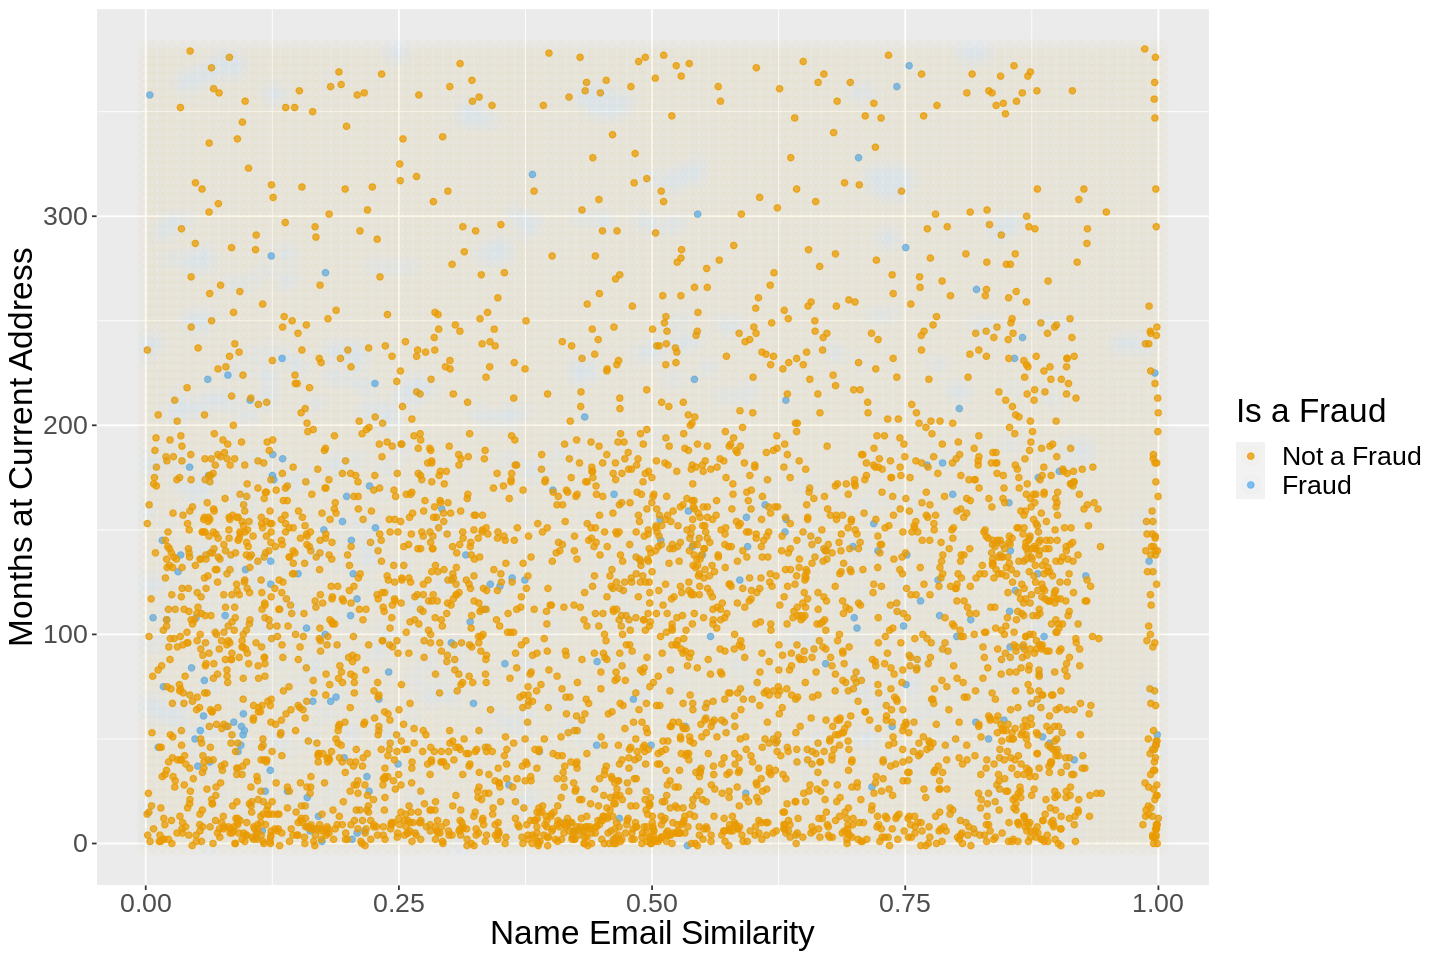

In [72]:

options(repr.plot.width=12, repr.plot.height=8)


ema_grid <- seq(min(fraud_test$name_email_similarity), 
                max(fraud_test$name_email_similarity), 
                length.out = 100)
add_grid <- seq(min(fraud_test$current_address_months_count), 
                max(fraud_test$current_address_months_count), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(name_email_similarity = ema_grid, 
                                current_address_months_count = add_grid))


knnPredGrid <- predict(knn_fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(Class = .pred_class)


final_plot <-
  ggplot() +
  geom_point(data = fraud_test, 
             mapping = aes(x = name_email_similarity, 
                           y = current_address_months_count, 
                           color = fraud_bool), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = name_email_similarity, 
                           y = current_address_months_count, 
                           color = Class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Is a Fraud", 
       x = "Name Email Similarity", 
       y = "Months at Current Address") +
  scale_color_manual(labels = c("Not a Fraud", "Fraud"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 20))

final_plot

## Discussion (Quick Notes Below)
 - Further discuss consequences of classifier performance (ie. whether performance is good enough)
 - Identify potential avenues of improvement, such as changing the ratio for oversampling.

## Expected outcomes and significance

#### What do we expect to find?
We expect that certain variables are better predictors of bank account fraud than others, and that the forward selection process will indicate which and how many variables to use to predict bank account fraud most accurately. Ultimately, we expect that a K-nearest neighbors classifier can be used to predict bank account fraud with a reasonable amount of accuracy.

#### What impact could such findings have?
With the knowledge of which variables are the strongest indicators of account opening fraud, banks could focus on collecting more data to a higher degree of detail on these variables. Besides that, if the K-nearest neighbors algorithm is shown to be effective in predicting account opening fraud, banks could use classifiers using this algorithm to quickly and efficiently identify which accounts should be monitored closely in order to expose cases of account opening fraud. If more fraudsters were caught and prosecuted, overall rates of account opening fraud would likely decrease.

#### What future questions could this lead to?

- Can K-nearest neighbors classifiers be used to detect other kinds of fraudulent banking activities, such as phishing scams, debit and credit card fraud, or cheque fraud?
- Can K-nearest neighbors classifiers be used to improve the accuracy and efficiency of current fraud detection systems?
- How would K-nearest neighbors compare to other classification algorithms (such as Naive Bayes, decision trees etc.) in identifying fraud?


## References